<a href="https://colab.research.google.com/github/pedrotorres08/TESE/blob/main/RFM_BT_r01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 90.0 MB/s eta 0:00:00


In [3]:
!pip install -q mapclassify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 1.9 MB/s eta 0:00:00


In [4]:
!pip install -q matplotlib_scalebar

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import contextily as cx
import random
from scipy import optimize
from scipy.stats import truncnorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc
import os
import mapclassify
from matplotlib_scalebar.scalebar import ScaleBar
from datetime import datetime, timedelta, date
import time
import matplotlib.dates as dates

In [6]:
def ler_cc_trafo(trafo):
  ndu = 22
  nsa = 4
  ndo = 4

  dfUC = UCBT[UCBT['UNI_TR_MT'] == trafo]

  df_add = pd.DataFrame()
  df_add.insert(0, 'dia', ['DU','SA','DO'])
  df_add = df_add.set_index('dia')

  for uc in range(len(dfUC)):
    CodCrvCrg = dfUC['TIP_CC'].iloc[uc]
    edu = np.array(CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'DU')]['E_DIA'])
    esa = np.array(CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'SA')]['E_DIA'])
    edo = np.array(CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'DO')]['E_DIA'])

    kWhmes = dfUC[UNTRMT['M_MAX'].loc[trafo]].iloc[uc]

    v1 = ndu*edu[0]
    v2 = nsa*esa[0]
    v3 = ndo*edo[0]
    coef = kWhmes/(v1+v2+v3)

    cc_du = coef*CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'DU')][['POT_{:02d}'.format(x) for x in range(1,97)]].set_axis(['DU'])#.reset_index(drop=True)
    cc_sa = coef*CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'SA')][['POT_{:02d}'.format(x) for x in range(1,97)]].set_axis(['SA'])#.reset_index(drop=True)
    cc_do = coef*CRVCRG[(CRVCRG['COD_ID'] == CodCrvCrg) & (CRVCRG['TIP_DIA'] == 'DO')][['POT_{:02d}'.format(x) for x in range(1,97)]].set_axis(['DO'])#.reset_index(drop=True)

    df_add = df_add.add(pd.concat([cc_du, cc_sa, cc_do], axis=0),fill_value=0)

  return df_add.T

def size_MFR(L,Dref,dt,pbase):
  #Calculate the MA of the load profiles @ interval u
  u = int(Dref/dt)
  len_L = len(L)

  L = pd.concat([L, L.iloc[0:u-1]], ignore_index=True)
  L['MA'] = L['DU'].rolling(window=u).mean()

  L.iloc[0:u-1] = L.iloc[-u+1:]
  L = L.iloc[0:len_L]

  P_mfr = max(L['DU'])*pbase
  E_mfr = max(L['MA'])*Dref*pbase
  return P_mfr,E_mfr,L

def calc_kWh(P_t,d,h,dt=0.25):
  P_2t = np.concatenate((P_t, P_t))
  ti_index = int(h/dt)
  tf_index = int((h+d)/dt)
  E_kWh = P_2t[ti_index:tf_index].sum()*dt
  return E_kWh

def calc_coef_d(E_kWh_trafo,dur_trafo,pxx):
  dftrafo = pd.DataFrame({'E_kWh': E_kWh_trafo, 'dur': dur_trafo})
  dur_evitada = dftrafo[dftrafo['E_kWh'] <= pxx].dur.sum()
  dur_ref = dftrafo.dur.sum()
  dur_n = dur_ref - dur_evitada
  coef_d = dur_n/dur_ref
  return coef_d

def calc_coef_d(E_kWh_trafo,dur_trafo,pxx):
  dftrafo = pd.DataFrame({'E_kWh': E_kWh_trafo, 'dur': dur_trafo})
  dur_evitada = dftrafo[dftrafo['E_kWh'] <= pxx].dur.sum()
  dur_ref = dftrafo.dur.sum()
  dur_n = dur_ref - dur_evitada
  coef_d = dur_n/dur_ref
  return coef_d

In [7]:
#Pasta com dados da TESE
pastadados = r"/content/drive/MyDrive/DADOS_TESE_R01"

In [33]:
#Dados de Entrada
conj = 14471
minEkWh = 1;
AnoRef = 2022

In [34]:
#Leitura dos dados de interrupção
dfinter = pd.read_parquet(pastadados + "/dfinter.parquet")

#Leitura dos dados de limites
dflim = pd.read_csv('{}/Indicadores/indicadores-continuidade-coletivos-limite.csv'.format(pastadados),encoding='latin-1',sep=';',on_bad_lines='skip',decimal=',')

#Leitura dos dados de compensacoes pagas
dfcomp = pd.concat([pd.read_csv('{}/Indicadores/indicadores-continuidade-coletivos-compensacao-2010-2019.csv'.format(pastadados),encoding='latin-1',decimal=',',sep=';',on_bad_lines='skip'),
                    pd.read_csv('{}/Indicadores/indicadores-continuidade-coletivos-compensacao-2020-2029.csv'.format(pastadados),encoding='latin-1',decimal=',',sep=';',on_bad_lines='skip')])

#Leitura dos dados de DEC e FEC dos conjuntos
dfcont = pd.concat([pd.read_csv('{}/Indicadores/indicadores-continuidade-coletivos-2010-2019.csv'.format(pastadados),encoding='latin-1',decimal=',',sep=';',on_bad_lines='skip'),
                    pd.read_csv('{}/Indicadores/indicadores-continuidade-coletivos-2020-2029.csv'.format(pastadados),encoding='latin-1',decimal=',',sep=';',on_bad_lines='skip')])

#Leitura da BDGD (versão 2023, ano base 2022)
UNTRMT = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='UNTRMT',where="CONJ='{}'".format(conj))
CRVCRG = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='CRVCRG')
UCBT = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='UCBT_tab',where="CONJ='{}'".format(conj))
UCMT = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='UCMT_tab',where="CONJ='{}'".format(conj))
SSDMT = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='SSDMT',where="CONJ='{}'".format(conj))
SUB = gpd.read_file('{}/EQUATORIAL_PA_371_2022-12-31_V11_20230905-1141.gdb.zip'.format(pastadados),layer='SUB',where="COD_ID='{}'".format(SSDMT.SUB.iloc[0]))

Tratamento de inconsistência na identificação dos circuitos

In [35]:
dfinter[dfinter.IdeConjuntoUnidadeConsumidora == conj].DscAlimentadorSubestacao.unique()

array(['GR-01', 'ME-02', '-'], dtype=object)

In [36]:
ctmt = UNTRMT.CTMT.unique()
print(ctmt)

['GURGR-01']


In [37]:
#Renomeando para compatibilizar a BDGD com o dfinter. Processo manual.
#dfinter['DscAlimentadorSubestacao'].replace({'01C1': 'CUO01C1', '01C2': 'CUO01C2', '01C3': 'CUO01C3',
#                                             '01C4': 'CUO01C4', '01C5': 'CUO01C5', '01C6': 'CUO01C6', '01C7': 'CUO01C7',
#                                             'UO-01': 'CUO01C1', 'UO-02': 'CUO01C2', 'UO-03': 'CUO01C3','UO-04': 'CUO01C4',
#                                             'UO-05': 'CUO01C5', 'UO-06': 'CUO01C6', 'UO-07': 'CUO01C7'},inplace=True) #Curió

#dfinter['DscAlimentadorSubestacao'].replace({'CI-02': 'BREBE-FC', 'CI-01': 'BREBE-FC'},inplace=True) #Curralinho

dfinter['DscAlimentadorSubestacao'].replace({'GR-01': 'GURGR-01'},inplace=True) #Gurupá

Avaliação Inicial

In [38]:
Agente = 'Equatorial PA       '
Anos = [2019,2020,2021,2022,2023]
indicadores = ['PGUCBTU','PGUCBTNU','PGUCBTUT','PGUCBTNUT','PGUCBTUA','PGUCBTNUA','PGUCBTUDC','PGUCBTNUDC']
dflim = dflim[(dflim.SigAgente == Agente) & (dflim.AnoLimiteQualidade.isin(Anos))][['IdeConjUndConsumidoras','DscConjUndConsumidoras','SigIndicador','AnoLimiteQualidade','VlrLimite']]
dfcomp = dfcomp[(dfcomp.SigAgente == Agente) & (dfcomp['SigIndicador'].isin(indicadores)) & (dfcomp.AnoIndice.isin(Anos))][['IdeConjUndConsumidoras','DscConjUndConsumidoras','SigIndicador','AnoIndice','NumPeriodoIndice','VlrIndiceEnviado']]
dfcont = dfcont[(dfcont.SigAgente == Agente) & (dfcont.AnoIndice.isin(Anos))][['IdeConjUndConsumidoras','DscConjUndConsumidoras','SigIndicador','AnoIndice','NumPeriodoIndice','VlrIndiceEnviado']]

In [39]:
dfcomp = dfcomp.drop(columns=['SigIndicador','DscConjUndConsumidoras','NumPeriodoIndice']).groupby(['IdeConjUndConsumidoras','AnoIndice']).sum().reset_index().rename(columns={'VlrIndiceEnviado':'Comp'})
dfDEC = dfcont[dfcont.SigIndicador == 'DEC'].drop(columns=['SigIndicador','NumPeriodoIndice']).groupby(['IdeConjUndConsumidoras','DscConjUndConsumidoras','AnoIndice']).sum().reset_index().rename(columns={'VlrIndiceEnviado':'DEC'})
dfFEC = dfcont[dfcont.SigIndicador == 'FEC'].drop(columns=['SigIndicador','NumPeriodoIndice']).groupby(['IdeConjUndConsumidoras','DscConjUndConsumidoras','AnoIndice']).sum().reset_index().rename(columns={'VlrIndiceEnviado':'FEC'})
dfDEClim = dflim[dflim.SigIndicador == 'DEC'].drop(columns=['SigIndicador']).reset_index(drop=True).rename(columns={'VlrLimite':'DEClim','AnoLimiteQualidade':'AnoIndice'})
dfFEClim = dflim[dflim.SigIndicador == 'FEC'].drop(columns=['SigIndicador']).reset_index(drop=True).rename(columns={'VlrLimite':'FEClim','AnoLimiteQualidade':'AnoIndice'})
dfDEClim.sort_values(by=['IdeConjUndConsumidoras','AnoIndice'],ascending=True,inplace=True)
dfFEClim.sort_values(by=['IdeConjUndConsumidoras','AnoIndice'],ascending=True,inplace=True)
dfDEClim.reset_index(drop=True,inplace=True)
dfFEClim.reset_index(drop=True,inplace=True)
df1 = pd.concat([dfDEC[['IdeConjUndConsumidoras','AnoIndice','DscConjUndConsumidoras','DEC']],dfFEC['FEC']],axis=1)
df2 = pd.concat([dfDEClim[['IdeConjUndConsumidoras','AnoIndice','DEClim']],dfFEClim['FEClim']],axis=1)
dfres = pd.merge(df1, df2,  how='left', left_on=['IdeConjUndConsumidoras','AnoIndice'], right_on = ['IdeConjUndConsumidoras','AnoIndice'])
dfres = pd.merge(dfres, dfcomp,  how='left', left_on=['IdeConjUndConsumidoras','AnoIndice'], right_on = ['IdeConjUndConsumidoras','AnoIndice'])
dfres['dDEC'] = dfres['DEC'] - dfres['DEClim']
dfres['dFEC'] = dfres['FEC'] - dfres['FEClim']

In [40]:
dDEC = dfres[(dfres['IdeConjUndConsumidoras'] == conj) & (dfres['AnoIndice'] == AnoRef)]['dDEC'].iloc[0]

In [41]:
DEC_conj = dfres[(dfres['IdeConjUndConsumidoras'] == conj) & (dfres['AnoIndice'] == AnoRef)]['DEC'].iloc[0]
FEC_conj = dfres[(dfres['IdeConjUndConsumidoras'] == conj) & (dfres['AnoIndice'] == AnoRef)]['FEC'].iloc[0]
DEClim_conj = dfres[(dfres['IdeConjUndConsumidoras'] == conj) & (dfres['AnoIndice'] == AnoRef)]['DEClim'].iloc[0]
FEClim_conj = dfres[(dfres['IdeConjUndConsumidoras'] == conj) & (dfres['AnoIndice'] == AnoRef)]['FEClim'].iloc[0]

Y_df

In [42]:
#Versao alternativa
r_seed = 48
n_amostras = 10000
Yd_list = []
Yh_list = []
conj_list = []
sub_list = []
alim_list = []
ctr = 0
dfinter_MT = dfinter[(dfinter.NumNivelTensao > 1200) & (dfinter.IdeConjuntoUnidadeConsumidora == conj) & (dfinter.DscAlimentadorSubestacao.isin(ctmt))][['IdeConjuntoUnidadeConsumidora','DscSubestacaoDistribuicao','DscAlimentadorSubestacao','DurInterrupcao','hi']]
s_total = len(list(dfinter_MT.DscAlimentadorSubestacao.unique()))
c_total = len(list(dfinter_MT.IdeConjuntoUnidadeConsumidora.unique()))

for conj in dfinter_MT.IdeConjuntoUnidadeConsumidora.unique():
  ctr = ctr + 1
  print('Progresso = {:.2f} %'.format(ctr/c_total*100))
  for sub in dfinter_MT[dfinter_MT.IdeConjuntoUnidadeConsumidora == conj].DscSubestacaoDistribuicao.unique():
    for alim in dfinter_MT[(dfinter_MT.IdeConjuntoUnidadeConsumidora == conj) & (dfinter_MT.DscSubestacaoDistribuicao == sub)].DscAlimentadorSubestacao.unique():

      #print('Progresso = {:.2f} %'.format(ctr/s_total*100))
      new_df = dfinter_MT.iloc[np.where((dfinter_MT["IdeConjuntoUnidadeConsumidora"].values == conj) &
                                        (dfinter_MT["DscSubestacaoDistribuicao"].values == sub) &
                                        (dfinter_MT["DscAlimentadorSubestacao"].values == alim))]
      if new_df.shape[0]> 100:
        df1 = new_df.DurInterrupcao
        df2 = new_df.hi

      else:
        new_df = dfinter_MT.iloc[np.where((dfinter_MT["IdeConjuntoUnidadeConsumidora"].values == conj) &
                                          (dfinter_MT["DscSubestacaoDistribuicao"].values == sub))]
        df1 = new_df.DurInterrupcao
        df2 = new_df.hi
        #Yd_list.append([[0] for x in range(n_amostras)])
        #Yh_list.append([[0] for x in range(n_amostras)])

      ##Duração
      #Primeiro, determinar o NP array
      Xd = np.array(df1).reshape(-1, 1)

      #Agora, fazer a magica
      kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(Xd)

      #Extrair amostras
      Yd = kde.sample(n_samples=n_amostras, random_state=r_seed)
      Yd_list.append(Yd)

      ##Horário
      #Primeiro, determinar o NP array
      Xh = np.array(df2).reshape(-1, 1)

      #Agora, fazer a magica
      kde = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(Xh)

      #Extrair amostras
      Yh = kde.sample(n_samples=n_amostras, random_state=r_seed)
      Yh_list.append(Yh)

      #Adicionar lista
      conj_list.append(conj)
      sub_list.append(sub)
      alim_list.append(alim)

Progresso = 100.00 %


In [43]:
Yd_list_new = [[Yd_list[k][j][0] for j in range(10000)] for k in range(len(Yd_list))]
Yh_list_new = [[Yh_list[k][j][0] for j in range(10000)] for k in range(len(Yh_list))]

Y_df = pd.DataFrame({'alim':alim_list,'conj':conj_list,'sub':sub_list,'Yd':Yd_list_new,'Yh':Yh_list_new})
Y_df = Y_df[Y_df['alim'].isin(ctmt)]
#Y_df.to_parquet(pastadados + "/Y_df_r01.parquet")
gc.collect

<function gc.collect(generation=2)>

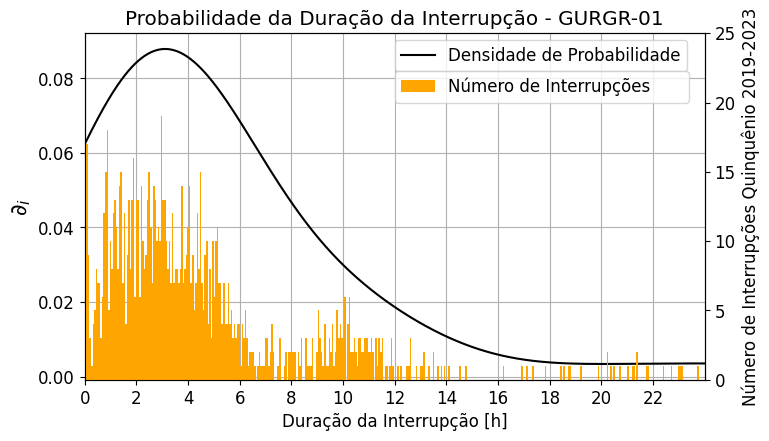

In [44]:
plt.rcParams.update({'font.size': 12})
for circuito in ctmt:
  #Duracao das interrupcoes
  df1 = dfinter_MT[(dfinter_MT.DscAlimentadorSubestacao == circuito)].DurInterrupcao

  if df1.shape[0]<= 100:
    df1m = dfinter_MT[(dfinter_MT.DscAlimentadorSubestacao.isin(ctmt))].DurInterrupcao
    ax = pd.concat([df1m],axis=1).plot.kde(figsize = (2.5*3.2,2.5*1.8),bw_method='silverman',ind=np.linspace(0,24,1000),grid=False,zorder=1)
  else:
    ax = pd.concat([df1],axis=1).plot.kde(figsize = (2.5*3.2,2.5*1.8),bw_method='silverman',ind=np.linspace(0,24,1000),grid=False,zorder=1)

  ax.set_xlabel('Duração da Interrupção [h]')
  ax.set_ylabel('$∂_i$',size= 16)
  ax.grid(visible=False)
  ax.set_xticks(range(0,24,2))
  #ax.set_yticks(np.linspace(0,0.225,10))
  ax.set_xlim(0,24)
  #ax.set_ylim(0,0.1)

  ax2 = ax.twinx()
  ax2.set_ylim(0,25)
  ax2.grid(visible=False)
  df1.hist(bins=np.linspace(0,24,400),ax=ax2,color='orange',grid=False,zorder=2)
  ax2.set_ylabel('Número de Interrupções Quinquênio 2019-2023')

  colors = ['black']
  for i, line in enumerate(ax.get_lines()):
      line.set_color(colors[i])

  ax.set_title('Probabilidade da Duração da Interrupção - {}'.format(circuito))
  ax.legend(labels=['Densidade de Probabilidade'],loc=(0.5,0.89))
  ax2.legend(labels=['Número de Interrupções      '],loc=(0.5,0.8))
  #ax.set_axisbelow(True)
  ax.grid(visible=True)
  ax.set_axisbelow(True)
  #ax2.legend(labels=['Histograma'],loc='upper left')
  #ax.set_title("Densidade de Probabilidade da Duração da Interrupção")~
  plt.savefig('{}/Figuras/Yd_{}.svg'.format(pastadados,circuito))

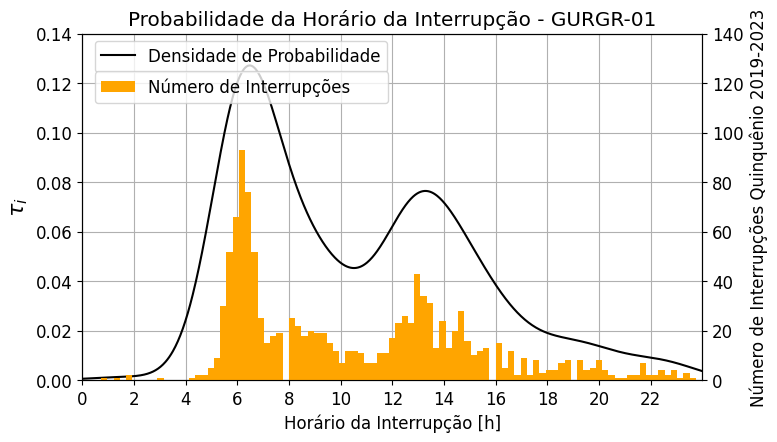

In [45]:
plt.rcParams.update({'font.size': 12})

for circuito in ctmt:
  #Horario das interrupcoes
  df1 = dfinter_MT[(dfinter_MT.DscAlimentadorSubestacao == circuito)].hi

  if df1.shape[0]<= 100:
    df1m = dfinter_MT[(dfinter_MT.DscAlimentadorSubestacao.isin(ctmt))].hi
    ax = pd.concat([df1m],axis=1).plot.kde(figsize = (2.5*3.2,2.5*1.8),bw_method='silverman',ind=np.linspace(0,24,1000),grid=False,zorder=1)
  else:
    ax = pd.concat([df1],axis=1).plot.kde(figsize = (2.5*3.2,2.5*1.8),bw_method='silverman',ind=np.linspace(0,24,1000),grid=False,zorder=1)

  ax.set_xlabel('Horário da Interrupção [h]')
  ax.set_ylabel('$τ_i$',size= 16)
  ax.grid(visible=True)
  ax.set_xticks(range(0,24,2))
  ax.set_xlim(0,24)
  ax.set_ylim(0,0.14)
  ax2 = ax.twinx()
  ax2.set_ylim(0,140)
  ax2.grid(visible=False)
  ln2 = df1.hist(bins=np.linspace(0,24,100),ax=ax2,color='orange',grid=False)
  ax2.set_ylabel('Número de Interrupções Quinquênio 2019-2023')
  ax.set_title('Probabilidade da Horário da Interrupção - {}'.format(circuito))

  colors = ['black','orange']
  for i, line in enumerate(ax.get_lines()):
      line.set_color(colors[i])

  ax.legend(labels=['Densidade de Probabilidade'],loc=(0.02,0.89))
  ax2.legend(labels=['Número de Interrupções      '],loc=(0.02,0.8))
  #ax.set_title("Densidade de Probabilidade do Horário de Ocorrência da Interrupção")
  ax.grid(visible=True)
  ax.set_axisbelow(True)
  plt.savefig('{}/Figuras/Yh_{}.svg'.format(pastadados,circuito))

EkWh

In [46]:
#Filtrar o Y_df
Y_df = Y_df[~Y_df['Yd'].apply(lambda x: np.all(x == 0))]
Y_df = Y_df[Y_df['conj'] == conj]

#Calcular a energia equivalente diaria de cada tipo de curva de carga
CRVCRG['E_DIA'] = CRVCRG[['POT_{:02d}'.format(x) for x in range(1,97)]].sum(axis=1)*0.25

#Atualizar UNTRMT
#UNTRMT['DscAlimentadorSubestacao'] = UNTRMT['CTMT'].apply(lambda x: x[-5:])
UNTRMT = UNTRMT.set_index('COD_ID')
UNTRMT['M_MAX'] = UCBT[['ENE_01','ENE_02','ENE_03','ENE_04','ENE_05','ENE_06','ENE_07','ENE_08','ENE_09','ENE_10','ENE_11','ENE_12']].mean().idxmax()

gc.collect()

54011

In [47]:
e_dict_list = []
P_t_dict = [{'conj':[],'sub':[],'alim':[],'trafo':[],'Pt':[]}]
e_kWh_df_list = []

for conj,sub,alim,Yd,Yh in zip(Y_df['conj'],Y_df['sub'],Y_df['alim'],Y_df['Yd'],Y_df['Yh']):
  print(conj,sub,alim)
  trafo_list = list(UNTRMT[(UNTRMT['SUB'] == sub) & (UNTRMT['CONJ'] == conj) & (UNTRMT['CTMT'].apply(lambda x: alim in x))].index)
  if trafo_list != []:
    Dref = dfinter.iloc[np.where((dfinter["DscAlimentadorSubestacao"].values == alim))].DurInterrupcao.mean()
    for trafo in trafo_list:
      if UCBT[UCBT['UNI_TR_MT'] == trafo].empty == False:
        #print(trafo)
        [P_mfr,E_mfr,L] = size_MFR(ler_cc_trafo(trafo),Dref,dt=0.25,pbase=1)
        #Curva de Carga
        df_cc_trafo = pd.concat([ler_cc_trafo(trafo)['DU'].reset_index(),L['MA']],axis=1)
        P_t = np.array(df_cc_trafo['DU'])
        P_t_dict.append({'conj':conj,'sub':sub,'alim':alim,'trafo':trafo,'Pt':P_t})

        #Calcular a energia necessaria em cada interrupcao
        E_kWh = [calc_kWh(P_t,d,h,dt=0.25) for d,h in zip(Yd,Yh)]

        #Salvar
        e_dict = {'conj':conj,'sub':sub,'alim':alim,'trafo':trafo,'P_t':P_mfr,'E_kWh':E_kWh, 'dur': Yd}
        e_dict_list.append(e_dict)
      else:
        print('trafo sem carga')

    E_kWh_df = pd.DataFrame(e_dict_list)
    E_kWh_df.to_parquet('{}/E_kWh/E_kWh_rx_{}.parquet'.format(pastadados,alim))
    e_kWh_df_list.append(E_kWh_df)
    del E_kWh_df, e_dict_list
    gc.collect()
    e_dict_list = []
    Ptdf = pd.DataFrame(P_t_dict).drop([0])

14471 GUR GURGR-01
trafo sem carga


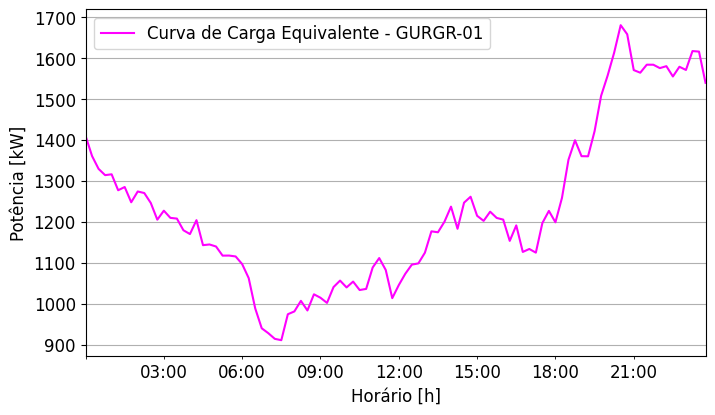

In [48]:
curva_eq = {}
for circuito in ctmt:
  dfaux =  Ptdf[Ptdf.alim == circuito]
  c_x = [cc for cc in dfaux.Pt]
  curva_eq[circuito] = np.sum(c_x,axis=0)
  ax = pd.DataFrame({'date':pd.date_range(start='00:00', end='23:45', freq='15min'),'P_t':curva_eq[circuito]}).set_index('date').plot(figsize = (2.5*3.2,2.5*1.8),grid=True,color='magenta')
  plt.gca().xaxis.set_major_locator(dates.HourLocator())
  plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%h'))
  plt.legend(labels=['Curva de Carga Equivalente - {}'.format(circuito)])
  plt.xlabel('Horário [h]')
  plt.ylabel('Potência [kW]')
  plt.savefig('{}/Figuras/Pt_{}.svg'.format(pastadados,circuito))
  plt.show()

In [49]:
E_df = pd.read_parquet('{}/E_kWh/E_kWh_rx_{}.parquet'.format(pastadados,ctmt[0]))

In [50]:
#Tratamento de dados de E_df
perc_e = [np.quantile(x, [0.25, 0.50, 0.75, 0.90]) for x in E_df['E_kWh']]
E_df = pd.concat([E_df,pd.DataFrame(perc_e, columns=['p25', 'p50', 'p75', 'p90'])],axis=1)

E_df = E_df[E_df['P_t'] != 0]
E_df = E_df.merge(UCBT[['RAMAL','UNI_TR_MT']].groupby(['UNI_TR_MT']).count().reset_index().rename(columns={"RAMAL": "NCONS","UNI_TR_MT": "trafo"}), on='trafo')
E_df = E_df[E_df['NCONS'] != 0]
E_df['E_per_UC'] = E_df['E_kWh']/E_df['NCONS']
E_df['coef_d_25'] = [calc_coef_d(E_kWh_trafo,dur_trafo,pxx) for E_kWh_trafo,dur_trafo,pxx in zip(E_df['E_kWh'],E_df['dur'],E_df['p25'])]
E_df['coef_d_50'] = [calc_coef_d(E_kWh_trafo,dur_trafo,pxx) for E_kWh_trafo,dur_trafo,pxx in zip(E_df['E_kWh'],E_df['dur'],E_df['p50'])]
E_df['coef_d_75'] = [calc_coef_d(E_kWh_trafo,dur_trafo,pxx) for E_kWh_trafo,dur_trafo,pxx in zip(E_df['E_kWh'],E_df['dur'],E_df['p75'])]
E_df['coef_d_90'] = [calc_coef_d(E_kWh_trafo,dur_trafo,pxx) for E_kWh_trafo,dur_trafo,pxx in zip(E_df['E_kWh'],E_df['dur'],E_df['p90'])]

In [51]:
#Obter DECp e FECp
a2 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2019)]['DECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2019)]['DEC'].iloc[0]
a3 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2020)]['DECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2020)]['DEC'].iloc[0]
a4 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2021)]['DECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2021)]['DEC'].iloc[0]
a5 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2022)]['DECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2022)]['DEC'].iloc[0]
a6 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2023)]['DECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2023)]['DEC'].iloc[0]
a = (a2+a3+a4+a5+a6)/5
b2 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2019)]['FECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2019)]['FEC'].iloc[0]
b3 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2020)]['FECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2020)]['FEC'].iloc[0]
b4 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2021)]['FECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2021)]['FEC'].iloc[0]
b5 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2022)]['FECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2022)]['FEC'].iloc[0]
b6 = dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2023)]['FECp'].iloc[0]/dfinter[(dfinter['IdeConjuntoUnidadeConsumidora'] == conj) & (dfinter['ANO'] == 2023)]['FEC'].iloc[0]
b = (b2+b3+b4+b5+b6)/5

DECtotal = pd.concat([UCMT[UCMT['CONJ'] == conj][['DIC_{:02d}'.format(x) for x in range(1,13)]],UCBT[UCBT['CONJ'] == conj][['DIC_{:02d}'.format(x) for x in range(1,13)]]],ignore_index=True).mean().sum()
FECtotal = pd.concat([UCMT[UCMT['CONJ'] == conj][['FIC_{:02d}'.format(x) for x in range(1,13)]],UCBT[UCBT['CONJ'] == conj][['FIC_{:02d}'.format(x) for x in range(1,13)]]],ignore_index=True).mean().sum()
DECptotal = DECtotal*a
FECptotal = FECtotal*b

print('coeficiente DECp: {:.2f}'.format(a))
print('coeficiente FECp: {:.2f}'.format(b))

coeficiente DECp: 0.79
coeficiente FECp: 0.90


In [52]:
ncons = UCMT.shape[0] + UCBT.shape[0]
ctbt_list = list(UCBT.UNI_TR_MT.unique())
DEC_ctbt_list = []
FEC_ctbt_list = []
coef_d_p25_list = []
coef_d_p50_list = []
coef_d_p75_list = []
coef_d_p90_list = []

for ctbt in ctbt_list:
  DECp_ctbt = (UCBT[UCBT['UNI_TR_MT'] == ctbt][['DIC_{:02d}'.format(x) for x in range(1,13)]].sum().div(ncons).sum())*a
  FECp_ctbt = (UCBT[UCBT['UNI_TR_MT'] == ctbt][['FIC_{:02d}'.format(x) for x in range(1,13)]].sum().div(ncons).sum())*b
  DEC_ctbt_list.append(DECp_ctbt)
  FEC_ctbt_list.append(FECp_ctbt)
  coef_d_p25_list.append(E_df[E_df['trafo'] == ctbt]['coef_d_25'].sum())
  coef_d_p50_list.append(E_df[E_df['trafo'] == ctbt]['coef_d_50'].sum())
  coef_d_p75_list.append(E_df[E_df['trafo'] == ctbt]['coef_d_75'].sum())
  coef_d_p90_list.append(E_df[E_df['trafo'] == ctbt]['coef_d_90'].sum())

dfCTBT = pd.DataFrame({'DEC': DEC_ctbt_list, 'FEC': FEC_ctbt_list, 'coef_d_p25': coef_d_p25_list, 'coef_d_p50': coef_d_p50_list,
                       'coef_d_p75': coef_d_p75_list, 'coef_d_p90': coef_d_p90_list}, index=ctbt_list)
dfCTBT['cDEC'] = dfCTBT['DEC']/DECptotal
dfCTBT['cFEC'] = dfCTBT['FEC']/FECptotal
dfCTBT = pd.concat([dfCTBT, E_df.set_index('trafo')[['P_t','p25','p50','p75','p90']]], axis=1, join="inner")
dfCTBT['DEC_p25'] = dfCTBT['DEC']*dfCTBT['coef_d_p25']
dfCTBT['DEC_p50'] = dfCTBT['DEC']*dfCTBT['coef_d_p50']
dfCTBT['DEC_p75'] = dfCTBT['DEC']*dfCTBT['coef_d_p75']
dfCTBT['DEC_p90'] = dfCTBT['DEC']*dfCTBT['coef_d_p90']
dfCTBT['FEC_p25'] = dfCTBT['FEC']*0.75
dfCTBT['FEC_p50'] = dfCTBT['FEC']*0.50
dfCTBT['FEC_p75'] = dfCTBT['FEC']*0.25
dfCTBT['FEC_p90'] = dfCTBT['FEC']*0.10
dfCTBT['dDEC%_p25'] = (- DECptotal + (DECptotal - dfCTBT['DEC'] + dfCTBT['DEC_p25']))/DECptotal*100
dfCTBT['dDEC%_p50'] = (- DECptotal + (DECptotal - dfCTBT['DEC'] + dfCTBT['DEC_p50']))/DECptotal*100
dfCTBT['dDEC%_p75'] = (- DECptotal + (DECptotal - dfCTBT['DEC'] + dfCTBT['DEC_p75']))/DECptotal*100
dfCTBT['dDEC%_p90'] = (- DECptotal + (DECptotal - dfCTBT['DEC'] + dfCTBT['DEC_p90']))/DECptotal*100
dfCTBT['dFEC%_p25'] = (- FECptotal + (FECptotal - dfCTBT['FEC'] + dfCTBT['FEC_p25']))/FECptotal*100
dfCTBT['dFEC%_p50'] = (- FECptotal + (FECptotal - dfCTBT['FEC'] + dfCTBT['FEC_p50']))/FECptotal*100
dfCTBT['dFEC%_p75'] = (- FECptotal + (FECptotal - dfCTBT['FEC'] + dfCTBT['FEC_p75']))/FECptotal*100
dfCTBT['dFEC%_p90'] = (- FECptotal + (FECptotal - dfCTBT['FEC'] + dfCTBT['FEC_p90']))/FECptotal*100
dfCTBT['dDEC%/kWh_p25'] = dfCTBT['dDEC%_p25']/dfCTBT['p25']
dfCTBT['dDEC%/kWh_p50'] = dfCTBT['dDEC%_p50']/dfCTBT['p50']
dfCTBT['dDEC%/kWh_p75'] = dfCTBT['dDEC%_p75']/dfCTBT['p75']
dfCTBT['dDEC%/kWh_p90'] = dfCTBT['dDEC%_p90']/dfCTBT['p90']
dfCTBT['dFEC%/kWh_p25'] = dfCTBT['dFEC%_p25']/dfCTBT['p25']
dfCTBT['dFEC%/kWh_p50'] = dfCTBT['dFEC%_p50']/dfCTBT['p50']
dfCTBT['dFEC%/kWh_p75'] = dfCTBT['dFEC%_p75']/dfCTBT['p75']
dfCTBT['dFEC%/kWh_p90'] = dfCTBT['dFEC%_p90']/dfCTBT['p90']
dfCTBT.reset_index(inplace=True)
dfCTBT.rename(columns={'index': 'trafo'},inplace=True)
#dfCTBT.to_parquet('dfCTBT_{}.parquet'.format(conj))
DECmin_ref = DECptotal-(DEC_conj-DEClim_conj)

Resumo

In [53]:
print('DEC do conjunto (2022): {:.2f} h'.format(DEC_conj))
print('FEC do conjunto (2022): {:.2f}'.format(FEC_conj))
print('DEC limite regulatório do conjunto (2022): {:.2f} h'.format(DEClim_conj))
print('FEC limite regulatório do conjunto (2022): {:.2f}'.format(FEClim_conj))
print('--')
print('DEC devido à UCs na BT (2022): {:.2f} h'.format(DECtotal))
print('FEC devido à UCs na BT (2022): {:.2f}'.format(FECtotal))
print('--')
print('Estimativa de DEC devido à UCs na BT com origem em eventos na MT (DECb,m) (2022): {:.2f} h'.format(DECptotal))
print('Estimativa de FEC devido à UCs na BT com origem em eventos na MT (FECb,m) (2022): {:.2f}'.format(FECptotal))
print('--')
if DEC_conj > DEClim_conj:
  print('O DEC do conjunto excede o limite regulatório em {:.2f} h'.format(DEC_conj-DEClim_conj))
  print('Para se enquadrar no limite regulatório, deve-se ter um DECb,m máximo de: {:.2f} h'.format(DECmin_ref))
  print('--')
  print('Se forem instaladas microrredes em todos os circuitos de BT do conjunto,')
  print('e dimensionadas para atendimento de 90 % das interrupções, tem-se um DECb,m de: {:.2f} h'.format(dfCTBT['DEC_p90'].sum()))
  print('--')
  if dfCTBT['DEC_p90'].sum() > DECmin_ref:
    print('Solução inviável considerando a melhoria de DEC exclusivamente devido microrredes na BT.')
  else:
    print('Solução técnicamente possível considerando a melhoria de DEC exclusivamente devido microrredes na BT.')
else:
  print('O DEC do conjunto não excede o limite regulatório')

DEC do conjunto (2022): 33.15 h
FEC do conjunto (2022): 16.69
DEC limite regulatório do conjunto (2022): 18.00 h
FEC limite regulatório do conjunto (2022): 23.00
--
DEC devido à UCs na BT (2022): 31.57 h
FEC devido à UCs na BT (2022): 15.89
--
Estimativa de DEC devido à UCs na BT com origem em eventos na MT (DECb,m) (2022): 24.80 h
Estimativa de FEC devido à UCs na BT com origem em eventos na MT (FECb,m) (2022): 14.34
--
O DEC do conjunto excede o limite regulatório em 15.15 h
Para se enquadrar no limite regulatório, deve-se ter um DECb,m máximo de: 9.65 h
--
Se forem instaladas microrredes em todos os circuitos de BT do conjunto,
e dimensionadas para atendimento de 90 % das interrupções, tem-se um DECb,m de: 11.27 h
--
Solução inviável considerando a melhoria de DEC exclusivamente devido microrredes na BT.


Otimização dos RFM em Baixa Tensão

In [60]:
#DECmin = dfCTBT['DEC'].sum()-dDEC
DECmin = 18

n_trafos = dfCTBT.shape[0]
p25 = np.array(dfCTBT['p25'])
p50 = np.array(dfCTBT['p50'])
p75 = np.array(dfCTBT['p75'])
p90 = np.array(dfCTBT['p90'])
DEC_p25 = np.array(dfCTBT['DEC_p25'])
DEC_p50 = np.array(dfCTBT['DEC_p50'])
DEC_p75 = np.array(dfCTBT['DEC_p75'])
DEC_p90 = np.array(dfCTBT['DEC_p90'])
DEC = np.array(dfCTBT['DEC'])

bounds = optimize.Bounds(0,1)
integrality = np.ones(5*n_trafos,int)
c = np.reshape(np.array([[np.zeros(n_trafos), p25, p50, p75, p90]]),5*n_trafos, order='F')

A = np.zeros((n_trafos, 5*n_trafos))
for i in range(n_trafos):
  A[i, 5*i:(5*i+5)] = 1
constraint_1 = optimize.LinearConstraint(A, 1, 1)

B = np.reshape(np.array([[DEC, DEC_p25, DEC_p50, DEC_p75, DEC_p90]]),5*n_trafos, order='F')
constraint_2 = optimize.LinearConstraint(B, 0, DECmin)

C = np.zeros((n_trafos, 5*n_trafos))
for i in range(n_trafos):
  C[i, 5*i:(5*i+5)] = np.reshape(np.array([[minEkWh*np.ones(n_trafos), p25, p50, p75, p90]]),5*n_trafos, order='F')[5*i:(5*i+5)]
constraint_3 = optimize.LinearConstraint(C, minEkWh, np.inf)

constraints = [constraint_1,constraint_2,constraint_3]

res = optimize.milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)

DEC estimado com RFM na BT: 18.00 h
Etotal: 1002.95 kWh


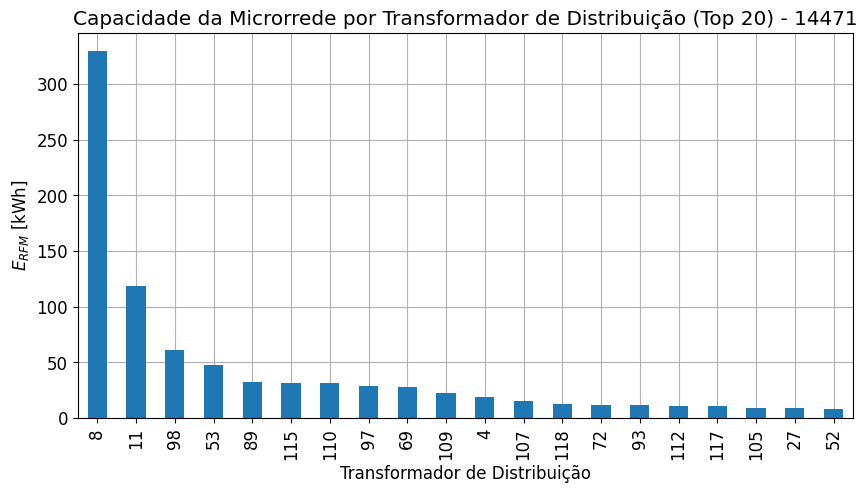

In [61]:
x0 = np.reshape(res.x, (5, n_trafos),order='F')[1]
x1 = np.reshape(res.x, (5, n_trafos),order='F')[2]
x2 = np.reshape(res.x, (5, n_trafos),order='F')[3]
x3 = np.reshape(res.x, (5, n_trafos),order='F')[4]
x = np.array([x0,x1,x2,x3])

E_trafo_list = np.sum(np.array([dfCTBT['p25'],dfCTBT['p50'],dfCTBT['p75'],dfCTBT['p90']])*x,axis=0)
E_total = np.sum(E_trafo_list)
DEC_res = np.sum(np.array(dfCTBT['DEC'])*(1-np.sum(x,axis=0)),axis=0) + np.sum(np.array([dfCTBT['DEC_p25'],dfCTBT['DEC_p50'],dfCTBT['DEC_p75'],dfCTBT['DEC_p90']])*x)

print("DEC estimado com RFM na BT: {:.2f} h\nEtotal: {:.2f} kWh".format(DEC_res,sum(E_trafo_list)))
dfCTBT['E_trafo'] = E_trafo_list
ax = dfCTBT[dfCTBT['E_trafo'] > 0].sort_values(by='E_trafo',ascending=False).head(20)['E_trafo'].plot.bar(figsize=(10,5),grid=True)
ax.set_axisbelow(True)
ax.set_ylabel('$E_{RFM}$ [kWh]')
ax.set_xlabel('Transformador de Distribuição')
ax.set_title('Capacidade da Microrrede por Transformador de Distribuição (Top 20) - {}'.format(conj))
plt.savefig("{}/Figuras/Top20_Capacidade_{}.svg".format(pastadados,conj))

In [62]:
UNTRMT['E_trafo'] = UNTRMT.index.map(dfCTBT.set_index('trafo')['E_trafo'])

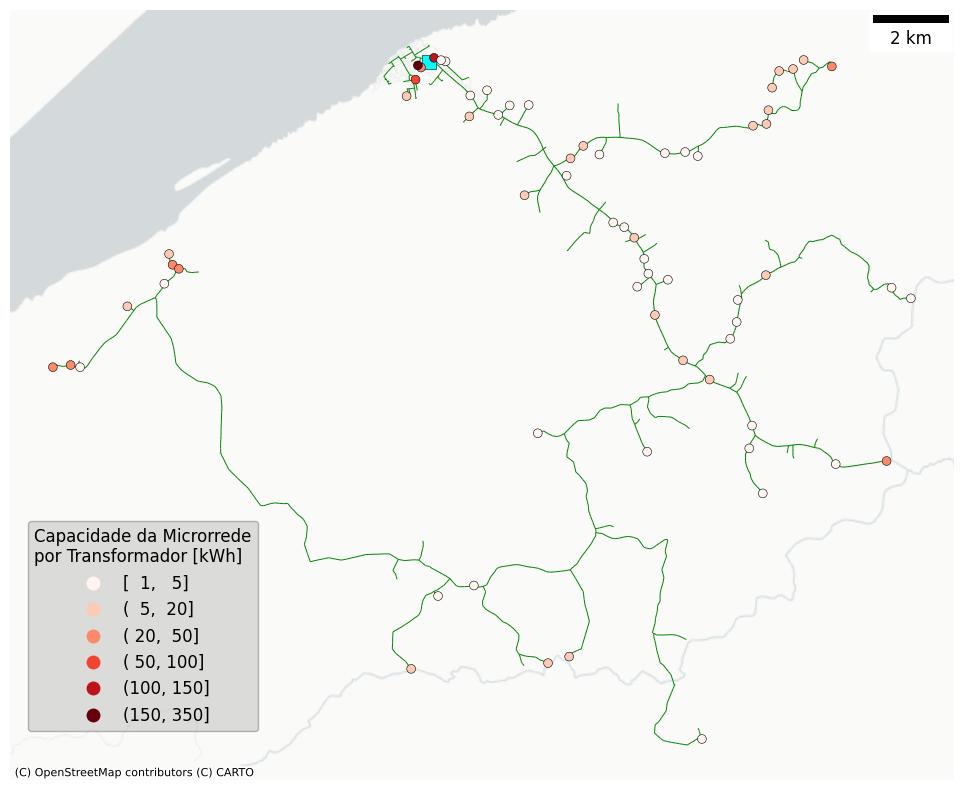

In [63]:
UNTRMT = UNTRMT.to_crs(epsg=3857)
SSDMT = SSDMT.to_crs(epsg=3857)
SUB = SUB.to_crs(epsg=3857)
base = SSDMT.plot(color='green',linewidth=0.7,zorder=1,figsize=(15,10));
leg_fig_x = 0.01 #0.8
leg_fig_y = 0.2 #0.85
leg_bins = [5,20,50,100,150,350]
UNTRMT[UNTRMT['E_trafo'] > 0].plot(ax=base, scheme='UserDefined', classification_kwds={'bins':leg_bins}, cmap="Reds", column="E_trafo", legend=True, edgecolor = 'black', linewidth = 0.4, marker='o', markersize=40,zorder=2,
                                   legend_kwds={'fontsize':12,'title':"Capacidade da Microrrede\npor Transformador [kWh]","title_fontsize":12,'framealpha':0.25,
                                                "loc": "center left",'facecolor':'grey','edgecolor':'black', "bbox_to_anchor": (leg_fig_x, leg_fig_y), "fmt": "{:.0f}","interval": True})
                                   #legend_kwds={"label": "Capacidade da Microrrede [kWh]", "orientation": "vertical", "ticks": [x for x in range(0, 46, 5)]})
SUB.representative_point().plot(ax=base,color='cyan', edgecolor = 'black', linewidth = 0.4, marker='s', markersize=100)
base.set_axis_off();
base.add_artist(ScaleBar(1))
cx.add_basemap(base,source=cx.providers.CartoDB.PositronNoLabels)
plt.savefig("{}/Figuras/Mapa_{}.svg".format(pastadados,conj))